In [1]:
import datetime
import random
import warnings
import time
import pickle

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from xgboost import XGBRegressor


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
plt.rcParams["figure.figsize"] = (15,9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# All Warnings are non-issues, but create significant clutter during printing
# So we choose to ignore them.
warnings.filterwarnings('ignore') 

# For reproduceability 
seed = 0

# It takes ~20 mins to run on a high-end system
start_time = time.time()

# Load Dataframes

Data is collected from https://open-meteo.com/ 
We collect Forecast and Archive Data. 
    - Forecast refers to the predicted values over the following week.
    - Archive refers to the historic data values.

In [2]:
DailyCity_Forecast = pd.read_csv("Weather Data/Daly City/forecast.csv", skiprows=3)
Fremont_Forecast = pd.read_csv("Weather Data/Fremont/forecast.csv", skiprows=3)
Hayward_Forecast = pd.read_csv("Weather Data/Hayward/forecast.csv", skiprows=3)
MountainView_Forecast = pd.read_csv("Weather Data/Mountain View/forecast.csv", skiprows=3)
Oakland_Forecast = pd.read_csv("Weather Data/Oakland/forecast.csv", skiprows=3)
PaloAlto_Forecast = pd.read_csv("Weather Data/Palo Alto/forecast.csv", skiprows=3)
RedwoodCity_Forecast = pd.read_csv("Weather Data/Redwood City/forecast.csv", skiprows=3)
SanFrancisco_Forecast = pd.read_csv("Weather Data/San Francisco/forecast.csv", skiprows=3)
SanJose_Forecast = pd.read_csv("Weather Data/San Jose/forecast.csv", skiprows=3)
SanMateo_Forecast = pd.read_csv("Weather Data/San Mateo/forecast.csv", skiprows=3)

In [3]:
DailyCity_Archive = pd.read_csv("Weather Data/Daly City/archive.csv", skiprows=3)
Fremont_Archive = pd.read_csv("Weather Data/Fremont/archive.csv", skiprows=3)
Hayward_Archive = pd.read_csv("Weather Data/Hayward/archive.csv", skiprows=3)
MountainView_Archive = pd.read_csv("Weather Data/Mountain View/archive.csv", skiprows=3)
Oakland_Archive = pd.read_csv("Weather Data/Oakland/archive.csv", skiprows=3)
PaloAlto_Archive = pd.read_csv("Weather Data/Palo Alto/archive.csv", skiprows=3)
RedwoodCity_Archive = pd.read_csv("Weather Data/Redwood City/archive.csv", skiprows=3)
SanFrancisco_Archive = pd.read_csv("Weather Data/San Francisco/archive.csv", skiprows=3)
SanJose_Archive = pd.read_csv("Weather Data/San Jose/archive.csv", skiprows=3)
SanMateo_Archive = pd.read_csv("Weather Data/San Mateo/archive.csv", skiprows=3)

In [4]:
def fixData_addCity(df, n, city):
    new_df = df.copy()
    for index, row in df.iloc[1:].iterrows():
        if row.isna().all(): 
            break
        try:
            time = int(row[0])
            new_time = datetime.datetime.fromtimestamp(time)
        except ValueError:
            continue
        new_df.at[index, 0] = new_time
    new_df = new_df.iloc[:-n]
    new_df["city"] = city
    return new_df

# Preprocessing Dataframes

Fix data frames to include city identifiers

Here "bottom_cut" cuts off the bottom N lines that are artifacts of the data collected from our source

In [5]:
bottom_cut = 17

DailyCity_Forecast = fixData_addCity(DailyCity_Forecast, bottom_cut, "Daily City")
Fremont_Forecast = fixData_addCity(Fremont_Forecast, bottom_cut, "Fremont")
Hayward_Forecast = fixData_addCity(Hayward_Forecast, bottom_cut, "Hayward")
MountainView_Forecast = fixData_addCity(MountainView_Forecast, bottom_cut, "Mountain View")
Oakland_Forecast = fixData_addCity(Oakland_Forecast, bottom_cut, "Oakland")
PaloAlto_Forecast = fixData_addCity(PaloAlto_Forecast, bottom_cut, "Palo Alto")
RedwoodCity_Forecast = fixData_addCity(RedwoodCity_Forecast, bottom_cut, "Redwood City")
SanFrancisco_Forecast = fixData_addCity(SanFrancisco_Forecast, bottom_cut, "San Francisco")
SanJose_Forecast = fixData_addCity(SanJose_Forecast, bottom_cut, "San Jose")
SanMateo_Forecast = fixData_addCity(SanMateo_Forecast, bottom_cut, "San Mateo")

In [6]:
bottom_cut = 2558

DailyCity_Archive = fixData_addCity(DailyCity_Archive, bottom_cut, "Daily City")
Fremont_Archive = fixData_addCity(Fremont_Archive, bottom_cut, "Fremont")
Hayward_Archive = fixData_addCity(Hayward_Archive, bottom_cut, "Hayward")
MountainView_Archive = fixData_addCity(MountainView_Archive, bottom_cut, "Mountain View")
Oakland_Archive = fixData_addCity(Oakland_Archive, bottom_cut, "Oakland")
PaloAlto_Archive = fixData_addCity(PaloAlto_Archive, bottom_cut, "Palo Alto")
RedwoodCity_Archive = fixData_addCity(RedwoodCity_Archive, bottom_cut, "Redwood City")
SanFrancisco_Archive = fixData_addCity(SanFrancisco_Archive, bottom_cut, "San Francisco")
SanJose_Archive = fixData_addCity(SanJose_Archive, bottom_cut, "San Jose")
SanMateo_Archive = fixData_addCity(SanMateo_Archive, bottom_cut, "San Mateo")

In [7]:
ForecastDF = [SanJose_Forecast, DailyCity_Forecast, Fremont_Forecast, Hayward_Forecast, MountainView_Forecast, Oakland_Forecast, PaloAlto_Forecast, RedwoodCity_Forecast, SanFrancisco_Forecast, SanMateo_Forecast]
ArchiveDF = [SanJose_Archive, DailyCity_Archive, Fremont_Archive, Hayward_Archive, MountainView_Archive, Oakland_Archive, PaloAlto_Archive, RedwoodCity_Archive, SanFrancisco_Archive, SanMateo_Archive]

### Necessary Feature Removal for Training

Given that two dataframes types are collected "forecast" and "archive" data. We want to remove any data from the Forecast
which is not present in the archive, and vice-versa. This will ensure that regression models are capable of prediction
as column data will be equivalent in nature.

In [8]:
def fixForecast(dfs):
    newList = []
    remove = [
        "precipitation_probability (%)",
        "showers (inch)",
        "snow_depth (ft)",
        "temperature_80m (°F)",
        "visibility (ft)",
        "winddirection_80m (°)",
        "windspeed_80m (mp/h)",
        "snowfall (inch)"
    ]
    for df in dfs:
        new_df = df.drop(columns=[col for col in remove if col in df.columns])
        newList.append(new_df)
    return newList

In [9]:
def fixArchive(dfs):
    newList = []
    remove = [
        "pressure_msl (hPa)",
        "surface_pressure (hPa)",
        "snowfall (inch)"
    ]
    for df in dfs:
        new_df = df.drop(columns=[col for col in remove if col in df.columns])
        newList.append(new_df)
    return newList

In [10]:
ForecastDF = fixForecast(ForecastDF)
ArchiveDF = fixArchive(ArchiveDF)

Concatonate the Dataframes into a single dataframe for simplier training

In [11]:
def concatDF(dataList):
    df = pd.concat(dataList)
    df.reset_index(drop=True, inplace=True)
    df["time"] = df["time"].apply(lambda x: int(x.timestamp()) if isinstance(x, datetime.datetime) else x)
    df.sort_values("time", inplace=True)
    df.reset_index(drop=True, inplace=True)
    df["time"] = df["time"].apply(lambda x: datetime.fromtimestamp(x) if isinstance(x, int) else x)
    return df

In [12]:
TotalForecastDF = concatDF(ForecastDF)
TotalArchiveDF = concatDF(ArchiveDF)

In [13]:
TotalForecastDF.head(5)
TotalArchiveDF.head(5)

,time,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch),rain (inch),cloudcover (%),windspeed_10m (mp/h),winddirection_10m (°),0,city
0,1681974000,49.2,71,0.000,0.000,0,2.2,217.0,NaT,San Jose
1,1681974000,44.8,78,0.000,0.000,0,2.6,290.0,NaT,Daily City
2,1681974000,46.8,76,0.000,0.000,0,4.8,283.0,NaT,San Mateo
3,1681974000,47.3,81,0.000,0.000,0,0.8,56.0,NaT,Hayward
4,1681974000,47.8,65,0.000,0.000,0,6.1,126.0,NaT,Mountain View


,time,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch),rain (inch),cloudcover (%),windspeed_10m (mp/h),winddirection_10m (°),0,city
0,1451631600,40.8,85,0.000,0.000,2,6.3,42,NaT,San Jose
1,1451631600,42.0,87,0.000,0.000,1,4.1,45,NaT,Fremont
2,1451631600,41.7,75,0.000,0.000,4,3.7,322,NaT,Hayward
3,1451631600,41.3,90,0.000,0.000,1,4.1,45,NaT,Mountain View
4,1451631600,40.8,82,0.000,0.000,1,3.5,45,NaT,San Mateo


In [14]:
def preprocessingDF(df, normalize_cols=[], onehot_cols=[]):
    def fixInternaldf(soleDF):
        soleDF = soleDF.dropna()
        new_df = soleDF.copy()
        for col in normalize_cols:
            new_df[col] = (new_df[col] - new_df[col].mean()) / new_df[col].std()
        new_df = pd.get_dummies(new_df, columns=onehot_cols)
        new_df['City_ID'] = new_df['city'].astype('category').cat.codes
        new_df = new_df.drop('city', axis=1)
        
        if '0' in new_df.columns:
            new_df = new_df.drop('0', axis=1)
        
        return new_df

    if isinstance(df, list):
        return [fixInternaldf(soleDF) for soleDF in df]
    else:
        return fixInternaldf(df)

In [15]:
processedForecast = preprocessingDF(TotalForecastDF)
processedArchive = preprocessingDF(TotalArchiveDF)

processedForecast = processedForecast.drop([0], axis=1)
processedArchive = processedArchive.drop([0], axis=1)

In [16]:
processedForecast.head(5)
processedArchive.head(5)

,time,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch),rain (inch),cloudcover (%),windspeed_10m (mp/h),winddirection_10m (°),City_ID
10,1681977600,46.5,72,0.000,0.000,0,3.6,277.0,7
11,1681977600,46.6,73,0.000,0.000,0,1.7,23.0,4
12,1681977600,46.8,63,0.000,0.000,0,1.8,256.0,6
13,1681977600,44.2,75,0.000,0.000,0,0.7,270.0,0
14,1681977600,46.7,77,0.000,0.000,2,4.9,120.0,2


,time,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch),rain (inch),cloudcover (%),windspeed_10m (mp/h),winddirection_10m (°),City_ID
10,1451635200,40.8,78,0.000,0.000,0,4.6,43,9
11,1451635200,40.7,90,0.000,0.000,0,4.6,43,5
12,1451635200,40.5,90,0.000,0.000,0,6.2,41,3
13,1451635200,42.8,85,0.000,0.000,0,4.6,43,6
14,1451635200,36.9,76,0.000,0.000,0,6.2,41,4


# Perform Principle Component Analysis on Features

Identify the useful features from the collected data.

In [17]:
def pcaAnalysis(df, target, num, path):
    features = df.drop(columns=[target])
    scale = StandardScaler()
    featuresNew = scale.fit_transform(features)

    pca = PCA(n_components=num)
    pca.fit(featuresNew)
    abss = np.abs(pca.components_.T)
    
    newDf = pd.DataFrame(abss, columns=[f"PC{i+1}" for i in range(num)], index=features.columns)
    sumSquareDF = (newDf ** 2).sum(axis=1)
    sortedDF = sumSquareDF.sort_values(ascending=False)

    ax = sortedDF.plot.bar(rot=90, figsize=(15, 8))
    ax.set_ylabel("PCA Contribution")
    ax.set_ylabel("Feature Columns")
    ax.set_title("Feature Contributions to Principal Components")
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

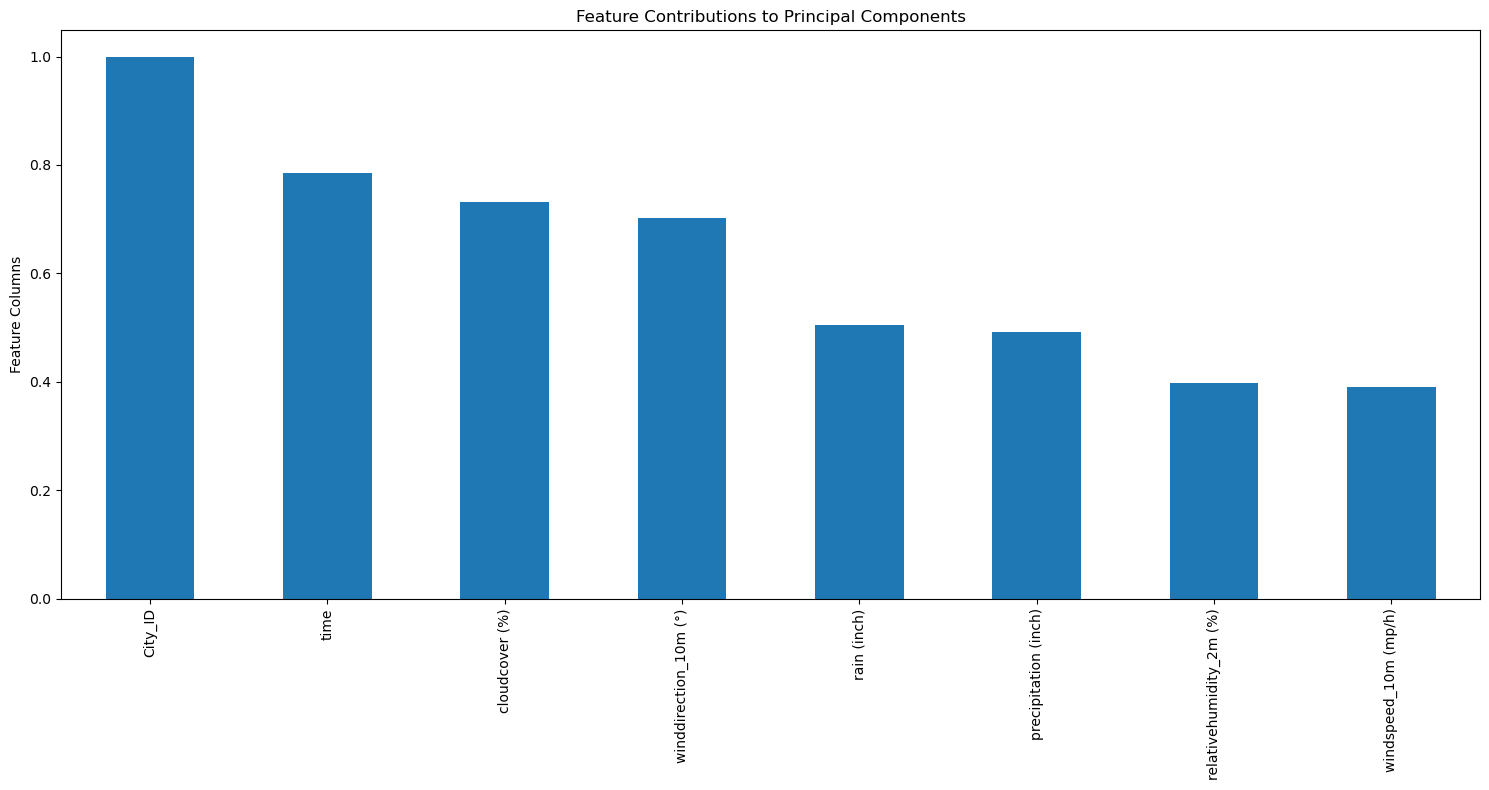

In [18]:
pcaAnalysis(processedForecast, "temperature_2m (°F)", 5, "Images/ForecastPCA.png")

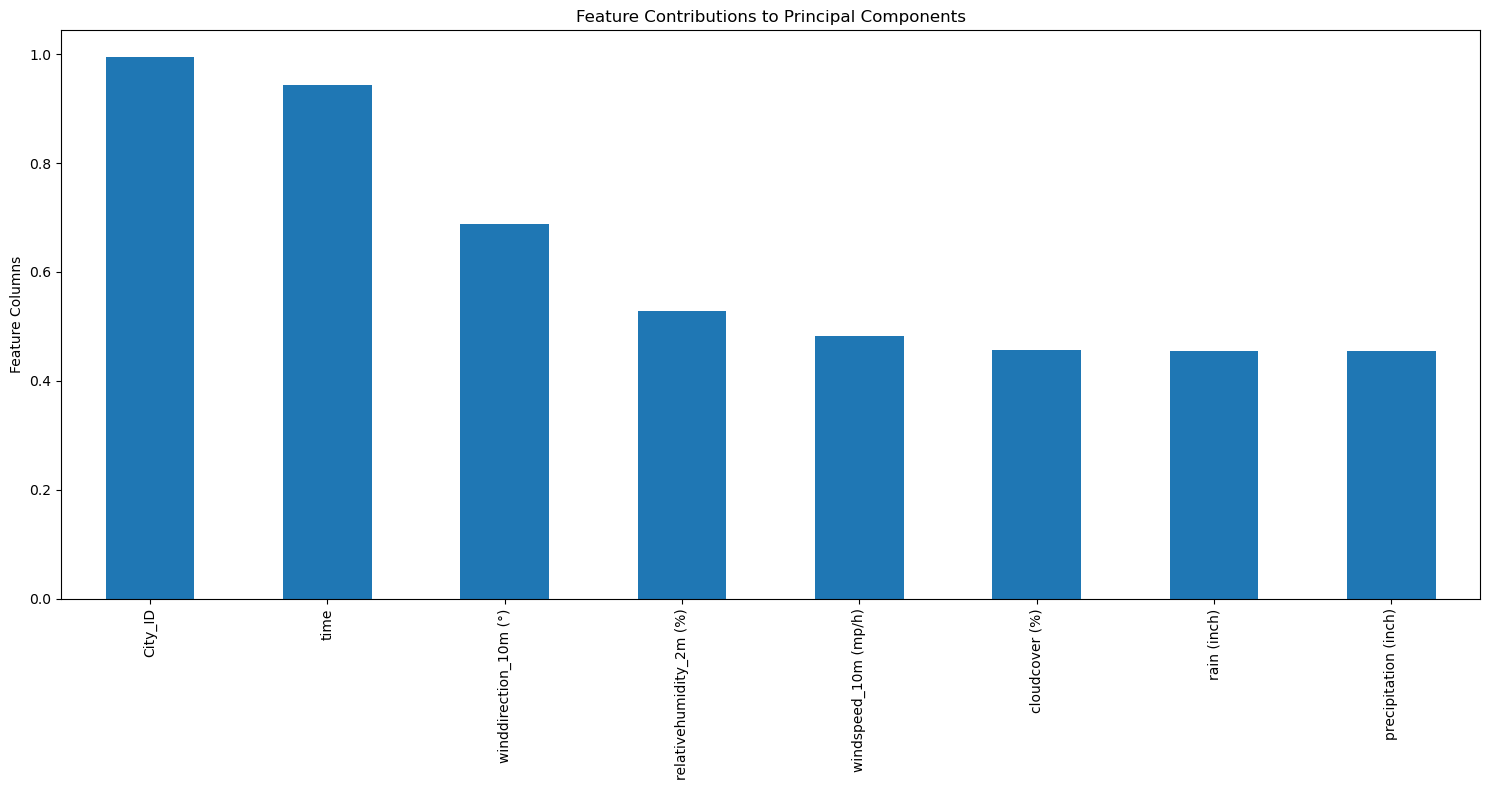

In [19]:
pcaAnalysis(processedArchive, "temperature_2m (°F)", 5, "Images/ArchivePCA.png")

As we can see CITY ID is crucial to feature contributions as well as time. These are both apparent, whats interesting 
is that windspeed is an indirect indicator of the tempurature as it contributes to city wide "cooling off".

# Training Regression Models

Preliminary testing to demonstrate effectiveness of the methods proposed.

In [20]:
def splitDF(df, target_col, num):    
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num, random_state=seed)
    return X_train, X_test, y_train, y_test

In [21]:
FX_train, FX_test, Fy_train, Fy_test = splitDF(processedForecast, "temperature_2m (°F)", .3)
AX_train, AX_test, Ay_train, Ay_test = splitDF(processedArchive, "temperature_2m (°F)", .3)

In [22]:
FrfReg = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(FX_train, Fy_train)
ArfReg = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(AX_train, Ay_train)

In [23]:
FrFRidge = Ridge(alpha=0.1).fit(FX_train, Fy_train)
ArFRidge = Ridge(alpha=0.1).fit(AX_train, Ay_train)

In [24]:
def getRMSE(model, X, y):
    pred = model.predict(X)
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    return rmse

In [25]:
print("Forecast Prediction Regression: ")
rmse = getRMSE(FrfReg, FX_test, Fy_test)
print("RMSE:", round(rmse, 6))

print("\nForecast Prediction Ridge: ")
rmse = getRMSE(FrFRidge, FX_test, Fy_test)
print("RMSE:", round(rmse, 6))

Forecast Prediction Regression: 
RMSE: 1.048904

Forecast Prediction Ridge: 
RMSE: 3.608618


In [26]:
print("Archive Prediction Regression: ")
rmse = getRMSE(ArfReg, AX_test, Ay_test)
print(rmse)

print("\nArchive Prediction Ridge: ")
rmse = getRMSE(ArFRidge, AX_test, Ay_test)
print(rmse)

Archive Prediction Regression: 
2.0053843369094317

Archive Prediction Ridge: 
6.585495142558209


In [27]:
print("Archive Prediction of Forecast using Regression: ")
rmse = getRMSE(ArfReg, FX_test, Fy_test)
print(rmse)

print("\nArchive Prediction of Forecast using Ridge: ")
rmse = getRMSE(ArFRidge, FX_test, Fy_test)
print(rmse)

Archive Prediction of Forecast using Regression: 
5.030519935685047

Archive Prediction of Forecast using Ridge: 
6.9318737680796


We can see that forecast and archive models are accurate in predicting their unseen test data.
With the Archive models being relatively accurate in predicting the unseen forecasting data over the next week.

## Build Testing Methodologies for different Regression Methods

In [28]:
def predictPolyRegML(df, target, remove, num, degree):
    rmse = []
    for i in range(num):
        randomCitys = random.sample(range(0, 10), remove)
        newDF = df[~df['City_ID'].isin(randomCitys)]
        X_train, X_test, y_train, y_test = splitDF(newDF, target, .3)
        poly_transform = PolynomialFeatures(degree=degree)
        X_train_poly = poly_transform.fit_transform(X_train)
        X_test_poly = poly_transform.transform(X_test)
        poly_regressor = LinearRegression(n_jobs=-1).fit(X_train_poly, y_train)
        rmse.append(getRMSE(poly_regressor, X_test_poly, y_test))
    return poly_regressor, rmse

In [29]:
def predictRidgeRegML(df, target, remove, num):
    rmse = []
    for i in range(num):
        randomCitys = random.sample(range(0, 10), remove)
        newDF = df[~df['City_ID'].isin(randomCitys)]
        X_train, X_test, y_train, y_test = splitDF(newDF, target, .3)
        ridge_regressor = Ridge(random_state=seed).fit(X_train, y_train)
        rmse.append(getRMSE(ridge_regressor, X_test, y_test))
    return ridge_regressor, rmse

In [30]:
def predictXGBRegML(df, target, remove, num):
    rmse = []
    for i in range(num):
        randomCitys = random.sample(range(0, 10), remove)
        newDF = df[~df['City_ID'].isin(randomCitys)]
        X_train, X_test, y_train, y_test = splitDF(newDF, target, .3)
        xgb_regressor = XGBRegressor(random_state=seed).fit(X_train, y_train)
        rmse.append(getRMSE(xgb_regressor, X_test, y_test))
    return xgb_regressor, rmse

In [31]:
def predictRFRegML(df, target, remove, num):
    rmse = []
    for i in range(num):
        randomCitys = random.sample(range(0, 10), remove)
        newDF = df[~df['City_ID'].isin(randomCitys)]
        X_train, X_test, y_train, y_test = splitDF(newDF, target, .3)
        rf_regressor = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(X_train, y_train)
        rmse.append(getRMSE(rf_regressor, X_test, y_test))
    return rf_regressor, rmse

In [32]:
def modelEval(modelType, data, num_iterations, degree, **kwargs):
    model_rmse = []
    best_rmse = 10000
    best_model = None

    for remove in range(9, -1, -1):
        print(f"{11-remove} Cities used for prediction")
        if degree == None:
            model, rmse_data = modelType(data, "temperature_2m (°F)", remove, num_iterations)
        else:
            model, rmse_data = predictPolyRegML(data, "temperature_2m (°F)", remove, num_iterations, degree)
        rmse = np.mean(rmse_data)
        if(rmse < best_rmse):
            best_rmse = rmse
            best_model = model
        model_rmse.append(round(rmse, 6))
        print(f"Avg. RMSE: ", round(rmse, 6))
        print("")
    return model_rmse, best_model

Below we drop a city from the training data. Then we build our models using the remaining cities. Lastly we will attempt
to predict the dropped cities tempuratures based on the model trained to predict the other cities.

In [33]:
def dropCity(df, num):
    num = str(num)
    mask = df["City_ID"].apply(lambda x: num in str(x))
    oldDF = df[~mask]
    newDF = df[mask]
    return oldDF, newDF

In [34]:
# 8 = San Jose on the City_ID

RemainingForecastData, soleCityForecastDF = dropCity(processedForecast, 8)
RemainingArchiveData, soleCityArchiveDF = dropCity(processedArchive, 8)

In [35]:
soleCityForecastDF.head(5)
soleCityArchiveDF.head(5)
RemainingForecastData.head(5)
RemainingArchiveData.head(5)

,time,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch),rain (inch),cloudcover (%),windspeed_10m (mp/h),winddirection_10m (°),City_ID
19,1681977600,48.4,71,0.000,0.000,0,2.4,229.0,8
23,1681981200,47.0,70,0.000,0.000,0,1.9,111.0,8
32,1681984800,46.0,70,0.000,0.000,0,0.6,45.0,8
43,1681988400,45.5,66,0.000,0.000,0,2.5,153.0,8
53,1681992000,44.7,66,0.000,0.000,0,2.2,180.0,8


,time,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch),rain (inch),cloudcover (%),windspeed_10m (mp/h),winddirection_10m (°),City_ID
18,1451635200,39.1,87,0.000,0.000,5,7.0,42,8
21,1451638800,38.1,87,0.000,0.000,2,7.0,40,8
36,1451642400,37.3,87,0.000,0.000,10,6.0,48,8
47,1451646000,35.8,88,0.000,0.000,12,6.3,42,8
59,1451649600,34.4,88,0.000,0.000,11,6.5,44,8


,time,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch),rain (inch),cloudcover (%),windspeed_10m (mp/h),winddirection_10m (°),City_ID
10,1681977600,46.5,72,0.000,0.000,0,3.6,277.0,7
11,1681977600,46.6,73,0.000,0.000,0,1.7,23.0,4
12,1681977600,46.8,63,0.000,0.000,0,1.8,256.0,6
13,1681977600,44.2,75,0.000,0.000,0,0.7,270.0,0
14,1681977600,46.7,77,0.000,0.000,2,4.9,120.0,2


,time,temperature_2m (°F),relativehumidity_2m (%),precipitation (inch),rain (inch),cloudcover (%),windspeed_10m (mp/h),winddirection_10m (°),City_ID
10,1451635200,40.8,78,0.000,0.000,0,4.6,43,9
11,1451635200,40.7,90,0.000,0.000,0,4.6,43,5
12,1451635200,40.5,90,0.000,0.000,0,6.2,41,3
13,1451635200,42.8,85,0.000,0.000,0,4.6,43,6
14,1451635200,36.9,76,0.000,0.000,0,6.2,41,4


In [36]:
# If the programs crashes here, rerun this block until it works, then continue.

print("Forecast: ")
RFSHFore, bestSJForeModel = modelEval(predictRFRegML, RemainingForecastData, 3, degree=None)
print(" ")
print("Archive: ")
RFSJArch, bestSJArchModel = modelEval(predictRFRegML, RemainingArchiveData, 3, degree=None)

Forecast: 
2 Cities used for prediction
Avg. RMSE:  1.782861

3 Cities used for prediction
Avg. RMSE:  1.531045

4 Cities used for prediction
Avg. RMSE:  1.359042

5 Cities used for prediction
Avg. RMSE:  1.392152

6 Cities used for prediction
Avg. RMSE:  1.317698

7 Cities used for prediction
Avg. RMSE:  1.206751

8 Cities used for prediction
Avg. RMSE:  1.061344

9 Cities used for prediction
Avg. RMSE:  1.120686

10 Cities used for prediction
Avg. RMSE:  0.959637

11 Cities used for prediction
Avg. RMSE:  0.863239

 
Archive: 
2 Cities used for prediction
Avg. RMSE:  3.197498

3 Cities used for prediction
Avg. RMSE:  2.695797

4 Cities used for prediction
Avg. RMSE:  2.820416

5 Cities used for prediction
Avg. RMSE:  2.617183

6 Cities used for prediction
Avg. RMSE:  2.377673

7 Cities used for prediction
Avg. RMSE:  2.301074

8 Cities used for prediction
Avg. RMSE:  2.159172

9 Cities used for prediction
Avg. RMSE:  2.113645

10 Cities used for prediction
Avg. RMSE:  1.911375

11 Ci

In [37]:
target_col = "temperature_2m (°F)"

SForeX_train, SForeX_test, SForey_train, SForey_test = splitDF(RemainingForecastData, target_col, .3)
SArchX_train, SArchX_test, SArchy_train, SArchy_test = splitDF(soleCityForecastDF, target_col, .3)
trX, teX, trY, teY = splitDF(RemainingArchiveData, target_col, .3)
traX, tesX, traY, tesY = splitDF(soleCityArchiveDF, target_col, .3)

In [38]:
SForeReg = RandomForestRegressor(n_estimators=100, random_state=seed).fit(SForeX_train, SForey_train)
SArchReg = RandomForestRegressor(n_estimators=100, random_state=seed).fit(SArchX_train, SArchy_train)

In [39]:
SJForepred = SForeReg.predict(SForeX_test)
mse = mean_squared_error(SForey_test, SJForepred)
rmse = mse**.5
print(f"San Jose Forecast RMSE: {rmse}")

SJArchpred = SForeReg.predict(SArchX_test)
mse = mean_squared_error(SArchy_test, SJArchpred)
rmse = mse**.5
print(f"San Jose Archive RMSE: {rmse}")

San Jose Forecast RMSE: 0.8632387313173434
San Jose Archive RMSE: 1.923731358358137


## Predict City Temps from Nearby Cities Archived Data

Directly below is a preliminary test of feasibility

In [40]:
def archiveOnForecast(train_df, test_df):
    X_train = train_df.drop("temperature_2m (°F)", axis=1)
    Y_train = train_df["temperature_2m (°F)"]
    X_test = test_df.drop("temperature_2m (°F)", axis=1)
    Y_test = test_df["temperature_2m (°F)"]
    reg = RandomForestRegressor(n_estimators=100, random_state=seed).fit(X_train, Y_train)
    Y_pred = reg.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = mse**.5
    return rmse

In [41]:
pred = archiveOnForecast(RemainingArchiveData, soleCityForecastDF)
print(f"Predicting San Jose Forecast from Neighboring City Archive Data: {pred}")

Predicting San Jose Forecast from Neighboring City Archive Data: 5.7338975521351285


Below we test if the removal or inclusion of more cities leads to better prediction scores on RMSE.

In [42]:
print("Forecast: ")
PolyForecastRMSE, PolybestForecastModel = modelEval(predictPolyRegML, processedForecast, 3, degree=4)
print(" ")
print("Archive: ")
PolyArchiveRMSE, PolybestArchiveModel = modelEval(predictPolyRegML, processedArchive, 3, degree=4)

Forecast: 
2 Cities used for prediction
Avg. RMSE:  2.626844

3 Cities used for prediction
Avg. RMSE:  2.831933

4 Cities used for prediction
Avg. RMSE:  3.58545

5 Cities used for prediction
Avg. RMSE:  2.913009

6 Cities used for prediction
Avg. RMSE:  2.938503

7 Cities used for prediction
Avg. RMSE:  2.983219

8 Cities used for prediction
Avg. RMSE:  2.976406

9 Cities used for prediction
Avg. RMSE:  2.938641

10 Cities used for prediction
Avg. RMSE:  3.164137

11 Cities used for prediction
Avg. RMSE:  2.890123

 
Archive: 
2 Cities used for prediction
Avg. RMSE:  5.952583

3 Cities used for prediction
Avg. RMSE:  6.302129

4 Cities used for prediction
Avg. RMSE:  6.351302

5 Cities used for prediction
Avg. RMSE:  5.938638

6 Cities used for prediction
Avg. RMSE:  6.173007

7 Cities used for prediction
Avg. RMSE:  6.142074

8 Cities used for prediction
Avg. RMSE:  6.224393

9 Cities used for prediction
Avg. RMSE:  6.153905

10 Cities used for prediction
Avg. RMSE:  6.123649

11 Cit

In [43]:
print("Forecast: ")
RidgeForecastRMSE, RidgebestForecastModel = modelEval(predictRidgeRegML, processedForecast, 3, degree=None)
print(" ")
print("Archive: ")
RidgeArchiveRMSE, RidgebestArchiveModel = modelEval(predictRidgeRegML, processedArchive, 3, degree=None)

Forecast: 
2 Cities used for prediction
Avg. RMSE:  3.457643

3 Cities used for prediction
Avg. RMSE:  3.463768

4 Cities used for prediction
Avg. RMSE:  3.514446

5 Cities used for prediction
Avg. RMSE:  3.570257

6 Cities used for prediction
Avg. RMSE:  3.631412

7 Cities used for prediction
Avg. RMSE:  3.561532

8 Cities used for prediction
Avg. RMSE:  3.553515

9 Cities used for prediction
Avg. RMSE:  3.653239

10 Cities used for prediction
Avg. RMSE:  3.609532

11 Cities used for prediction
Avg. RMSE:  3.623391

 
Archive: 
2 Cities used for prediction
Avg. RMSE:  6.347392

3 Cities used for prediction
Avg. RMSE:  6.559174

4 Cities used for prediction
Avg. RMSE:  6.464795

5 Cities used for prediction
Avg. RMSE:  6.902859

6 Cities used for prediction
Avg. RMSE:  6.614728

7 Cities used for prediction
Avg. RMSE:  6.434196

8 Cities used for prediction
Avg. RMSE:  6.599993

9 Cities used for prediction
Avg. RMSE:  6.598951

10 Cities used for prediction
Avg. RMSE:  6.527348

11 Ci

In [44]:
print("Forecast: ")
RFForecastRMSE, RFbestForecastModel = modelEval(predictRFRegML, processedForecast, 3, degree=None)
print(" ")
print("Archive: ")
RFArchiveRMSE, RFbestArchiveModel = modelEval(predictRFRegML, processedArchive, 3, degree=None)

Forecast: 
2 Cities used for prediction
Avg. RMSE:  1.679918

3 Cities used for prediction
Avg. RMSE:  1.732412

4 Cities used for prediction
Avg. RMSE:  1.336383

5 Cities used for prediction
Avg. RMSE:  1.275526

6 Cities used for prediction
Avg. RMSE:  1.282068

7 Cities used for prediction
Avg. RMSE:  1.081638

8 Cities used for prediction
Avg. RMSE:  1.132268

9 Cities used for prediction
Avg. RMSE:  1.100152

10 Cities used for prediction
Avg. RMSE:  0.933728

11 Cities used for prediction
Avg. RMSE:  1.048904

 
Archive: 
2 Cities used for prediction
Avg. RMSE:  3.024168

3 Cities used for prediction
Avg. RMSE:  2.725175

4 Cities used for prediction
Avg. RMSE:  2.763304

5 Cities used for prediction
Avg. RMSE:  2.489768

6 Cities used for prediction
Avg. RMSE:  2.388281

7 Cities used for prediction
Avg. RMSE:  2.170521

8 Cities used for prediction
Avg. RMSE:  2.094962

9 Cities used for prediction
Avg. RMSE:  2.149984

10 Cities used for prediction
Avg. RMSE:  2.089999

11 Ci

In [45]:
def XGCleanUp(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
            df[col] = df[col].cat.codes
    return df

XGprocessedArchive = XGCleanUp(processedArchive)
XGprocessedForecast = XGCleanUp(processedForecast)

In [46]:
print("Forecast: ")
XGBForecastRMSE, XGBbestForecastModel = modelEval(predictXGBRegML, XGprocessedForecast, 3, degree=None)
print(" ")
print("Archive: ")
XGBArchiveRMSE, XGBbestArchiveModel = modelEval(predictXGBRegML, XGprocessedArchive, 3, degree=None)

Forecast: 
2 Cities used for prediction
Avg. RMSE:  15.017301

3 Cities used for prediction
Avg. RMSE:  12.982244

4 Cities used for prediction
Avg. RMSE:  10.83699

5 Cities used for prediction
Avg. RMSE:  9.787098

6 Cities used for prediction
Avg. RMSE:  9.008367

7 Cities used for prediction
Avg. RMSE:  8.568128

8 Cities used for prediction
Avg. RMSE:  8.64114

9 Cities used for prediction
Avg. RMSE:  8.26889

10 Cities used for prediction
Avg. RMSE:  7.665864

11 Cities used for prediction
Avg. RMSE:  7.475932

 
Archive: 
2 Cities used for prediction
Avg. RMSE:  24.919596

3 Cities used for prediction
Avg. RMSE:  25.221384

4 Cities used for prediction
Avg. RMSE:  27.8564

5 Cities used for prediction
Avg. RMSE:  28.470438

6 Cities used for prediction
Avg. RMSE:  26.043055

7 Cities used for prediction
Avg. RMSE:  27.434519

8 Cities used for prediction
Avg. RMSE:  27.95339

9 Cities used for prediction
Avg. RMSE:  27.32467

10 Cities used for prediction
Avg. RMSE:  27.294863



# Plot RMSE Data

Notably, we exlude any models, such as XGBoost Regression, when the RMSE scores are poor to improve model viewing.

Text(0.5, 0, 'Number of Cities Used')

Text(0, 0.5, 'Error Value')

Text(0.5, 1.0, 'RMSE of Archive Regression Models')

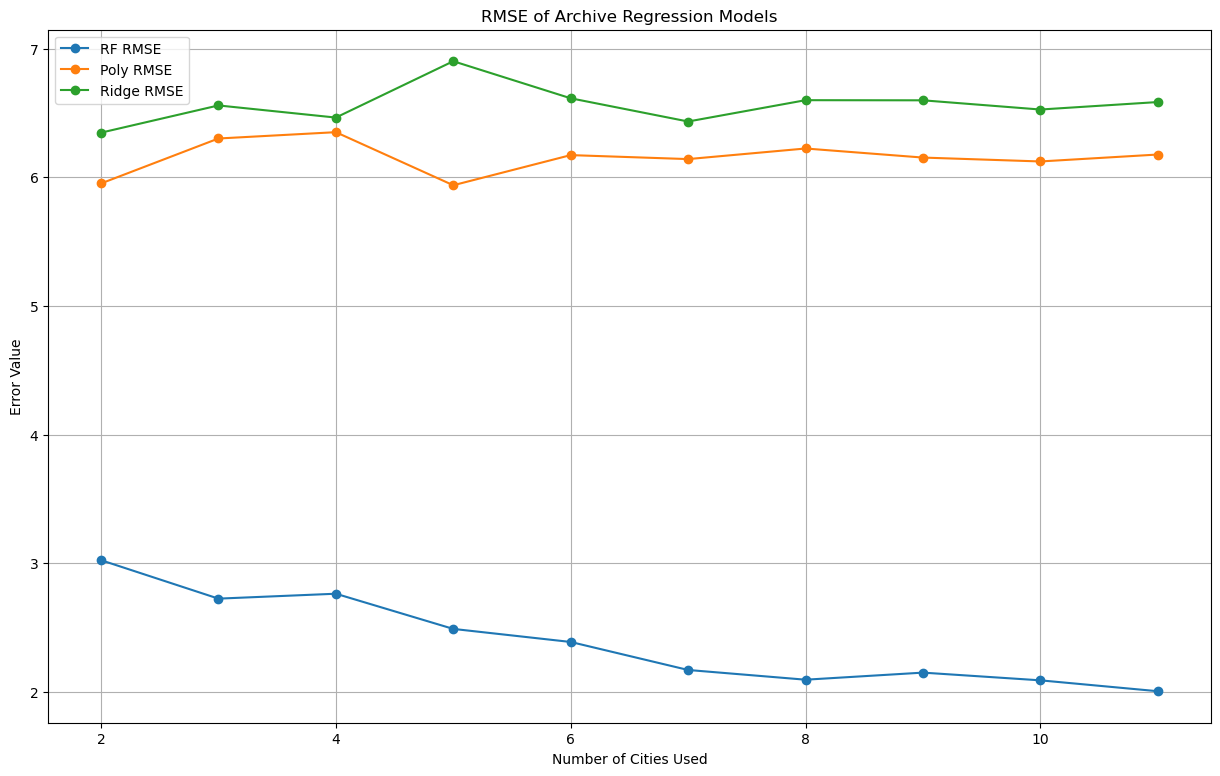

In [47]:
cityCount = [11 - i for i in range(9, -1, -1)]

plt.plot(cityCount, RFArchiveRMSE, label="RF RMSE", marker="o")
plt.plot(cityCount, PolyArchiveRMSE, label="Poly RMSE", marker="o")
plt.plot(cityCount, RidgeArchiveRMSE, label="Ridge RMSE", marker="o")
#plt.plot(cityCount, XGBArchiveRMSE, label="XGB RMSE", marker="o")

plt.xlabel("Number of Cities Used")
plt.ylabel("Error Value")
plt.title("RMSE of Archive Regression Models")

plt.legend()
plt.grid(True)
plt.savefig("Images/Archive_Regression_RMSE.png")
plt.show()

Text(0.5, 0, 'Number of Cities Used')

Text(0, 0.5, 'Error Value')

Text(0.5, 1.0, 'RMSE of Forecast Regression Models')

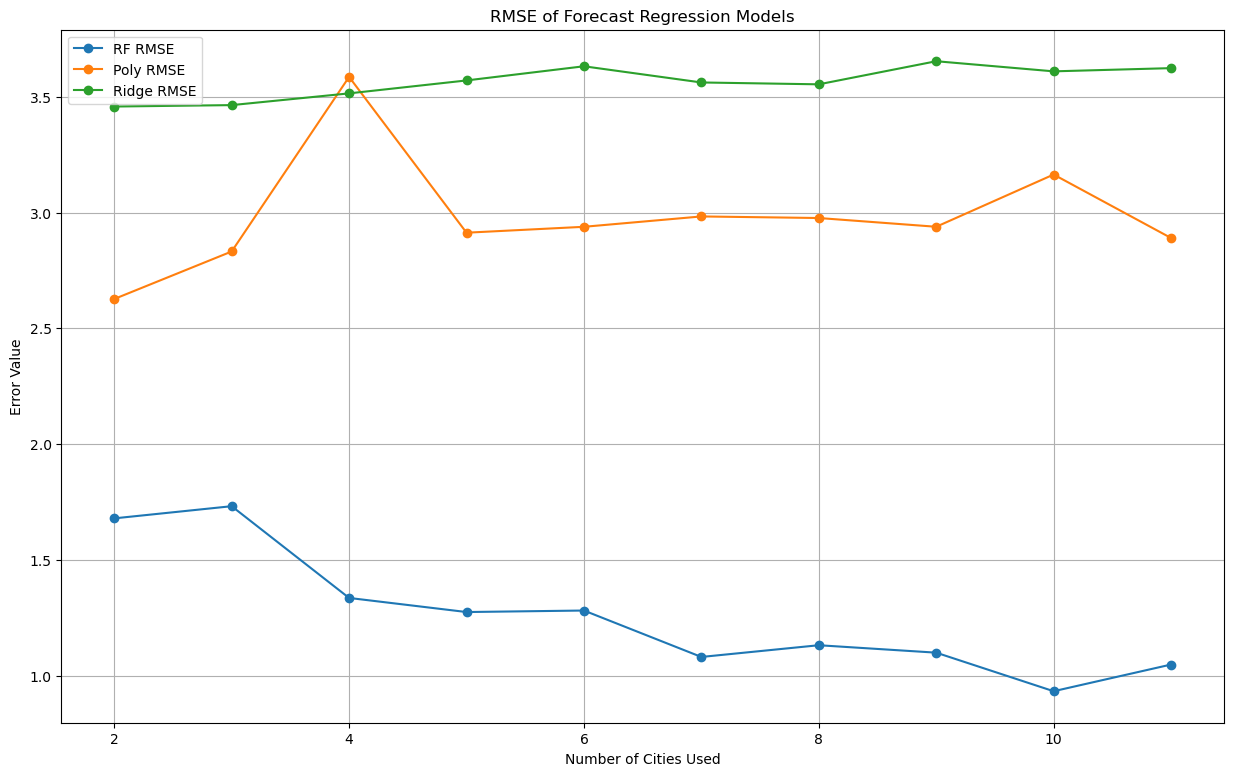

In [48]:
plt.plot(cityCount, RFForecastRMSE, label="RF RMSE", marker="o")
plt.plot(cityCount, PolyForecastRMSE, label="Poly RMSE", marker="o")
plt.plot(cityCount, RidgeForecastRMSE, label="Ridge RMSE", marker="o")
#plt.plot(cityCount, XGBForecastRMSE, label="XGB RMSE", marker="o")

plt.xlabel("Number of Cities Used")
plt.ylabel("Error Value")
plt.title("RMSE of Forecast Regression Models")

plt.legend()
plt.grid(True)
plt.savefig("Images/Forecast_Regression_RMSE.png")
plt.show()

# Now we Test SJ Temperature Predictions from Increased City Counts

In [49]:
def newModel(fullData, singleData, target, degree, model_type, device):
    model_rmse = []
    best_rmse = 10000
    best_model = None
    _, X_test, _, y_test = splitDF(singleData, target, .99)  # Large Testing Set
    for remove in range(9, 0, -1):
        print(f"{remove} Cities used for Prediction")
        randomCitys = random.sample([i for i in range(10) if i != 8], remove)
        newDF = fullData[fullData['City_ID'].isin(randomCitys)]
        X_train, _, y_train, _ = splitDF(newDF, target, .05)  # Large Training Set
        if model_type == 'polynomial':
            poly_transform = PolynomialFeatures(degree=degree)
            model = LinearRegression(n_jobs=-1)
        elif model_type == 'random_forest':
            model = RandomForestRegressor(n_jobs=-1, n_estimators=50, random_state=seed)
        elif model_type == 'ridge':
            model = Ridge()
        elif model_type == 'xgboost':
            model = XGBRegressor(n_jobs=-1, tree_method='gpu_hist', gpu_id=0) if device == 'cuda' else XGBRegressor(n_jobs=-1)
        model.fit(X_train, y_train)
        rmse_data = getRMSE(model, X_test, y_test)
        rmse = np.mean(rmse_data)
        if (rmse < best_rmse):
            best_rmse = rmse
            best_model = model
        model_rmse.append(round(rmse, 6))
        print(f"Avg. RMSE: ", round(rmse, 6))
        print("")
    return model_rmse, best_model

In [50]:
processedForecast = preprocessingDF(TotalForecastDF)
processedArchive = preprocessingDF(TotalArchiveDF)

processedForecast = processedForecast.drop([0], axis=1)
processedArchive = processedArchive.drop([0], axis=1)

In [51]:
RemainingForecastData, soleCityForecastDF = dropCity(processedForecast, 8)
RemainingArchiveData, soleCityArchiveDF = dropCity(processedArchive, 8)

### Idea of Folowing Repeating Lines:
#### Given Archive Data of All Data but the prediction city data, can we predict the prediction city's forecast this week. 

In [52]:
print("SJ Temp. Pred. from Archive: ")
Polyrmse, PolyModel = newModel(RemainingArchiveData, soleCityForecastDF, "temperature_2m (°F)", 4, 'polynomial', device)
print(" ")

SJ Temp. Pred. from Archive: 
9 Cities used for Prediction
Avg. RMSE:  7.802792

8 Cities used for Prediction
Avg. RMSE:  8.017432

7 Cities used for Prediction
Avg. RMSE:  7.890021

6 Cities used for Prediction
Avg. RMSE:  7.529887

5 Cities used for Prediction
Avg. RMSE:  7.570114

4 Cities used for Prediction
Avg. RMSE:  7.21592

3 Cities used for Prediction
Avg. RMSE:  7.953532

2 Cities used for Prediction
Avg. RMSE:  7.021495

1 Cities used for Prediction
Avg. RMSE:  8.827056

 


In [53]:
print("SJ Temp. Pred. from Archive: ")
Ridgermse, RidgeModel = newModel(RemainingArchiveData, soleCityForecastDF, "temperature_2m (°F)", None, 'ridge', device)
print(" ")

SJ Temp. Pred. from Archive: 
9 Cities used for Prediction
Avg. RMSE:  7.802885

8 Cities used for Prediction
Avg. RMSE:  7.716033

7 Cities used for Prediction
Avg. RMSE:  7.577055

6 Cities used for Prediction
Avg. RMSE:  7.628172

5 Cities used for Prediction
Avg. RMSE:  7.650708

4 Cities used for Prediction
Avg. RMSE:  8.331364

3 Cities used for Prediction
Avg. RMSE:  7.062545

2 Cities used for Prediction
Avg. RMSE:  7.051943

1 Cities used for Prediction
Avg. RMSE:  8.167503

 


In [54]:
print("SJ Temp. Pred. from Archive: ")
RFrmse, RFmodel = newModel(RemainingArchiveData, soleCityForecastDF, "temperature_2m (°F)", None, 'random_forest', device)
print(" ")

SJ Temp. Pred. from Archive: 
9 Cities used for Prediction
Avg. RMSE:  5.77457

8 Cities used for Prediction
Avg. RMSE:  6.122423

7 Cities used for Prediction
Avg. RMSE:  6.107219

6 Cities used for Prediction
Avg. RMSE:  6.025555

5 Cities used for Prediction
Avg. RMSE:  6.265258

4 Cities used for Prediction
Avg. RMSE:  5.837744

3 Cities used for Prediction
Avg. RMSE:  5.505996

2 Cities used for Prediction
Avg. RMSE:  5.456935

1 Cities used for Prediction
Avg. RMSE:  6.134516

 


In [55]:
XGprocessedArchive = XGCleanUp(RemainingArchiveData)
XGprocessedForecast = XGCleanUp(soleCityForecastDF)

print("SJ Temp. Pred. from Archive: ")
XGBrmse, XGBmodel = newModel(XGprocessedArchive, XGprocessedForecast, "temperature_2m (°F)", None, 'xgboost', device)
print(" ")

SJ Temp. Pred. from Archive: 
9 Cities used for Prediction
Avg. RMSE:  318.15945

8 Cities used for Prediction
Avg. RMSE:  313.3837

7 Cities used for Prediction
Avg. RMSE:  307.7953

6 Cities used for Prediction
Avg. RMSE:  306.63342

5 Cities used for Prediction
Avg. RMSE:  305.26462

4 Cities used for Prediction
Avg. RMSE:  311.351

3 Cities used for Prediction
Avg. RMSE:  290.7212

2 Cities used for Prediction
Avg. RMSE:  267.0866

1 Cities used for Prediction
Avg. RMSE:  307.21204

 


In [56]:
with open('Models/Polynomial_Regression_Model.pkl', 'wb') as file:
    pickle.dump(PolyModel, file)

In [57]:
with open('Models/Ridge_Regression_Model.pkl', 'wb') as file:
    pickle.dump(RidgeModel, file)

In [58]:
with open('Models/Random_Forrest_Regression_Model.pkl', 'wb') as file:
    pickle.dump(RFmodel, file)

In [59]:
with open('Models/XGBoost_Regression_Model.pkl', 'wb') as file:
    pickle.dump(XGBmodel, file)

Text(0.5, 0, 'Number of Cities Used')

Text(0, 0.5, 'Error Value')

Text(0.5, 1.0, 'RMSE of SJ Tempurature given Archive data of Nearby Cities')

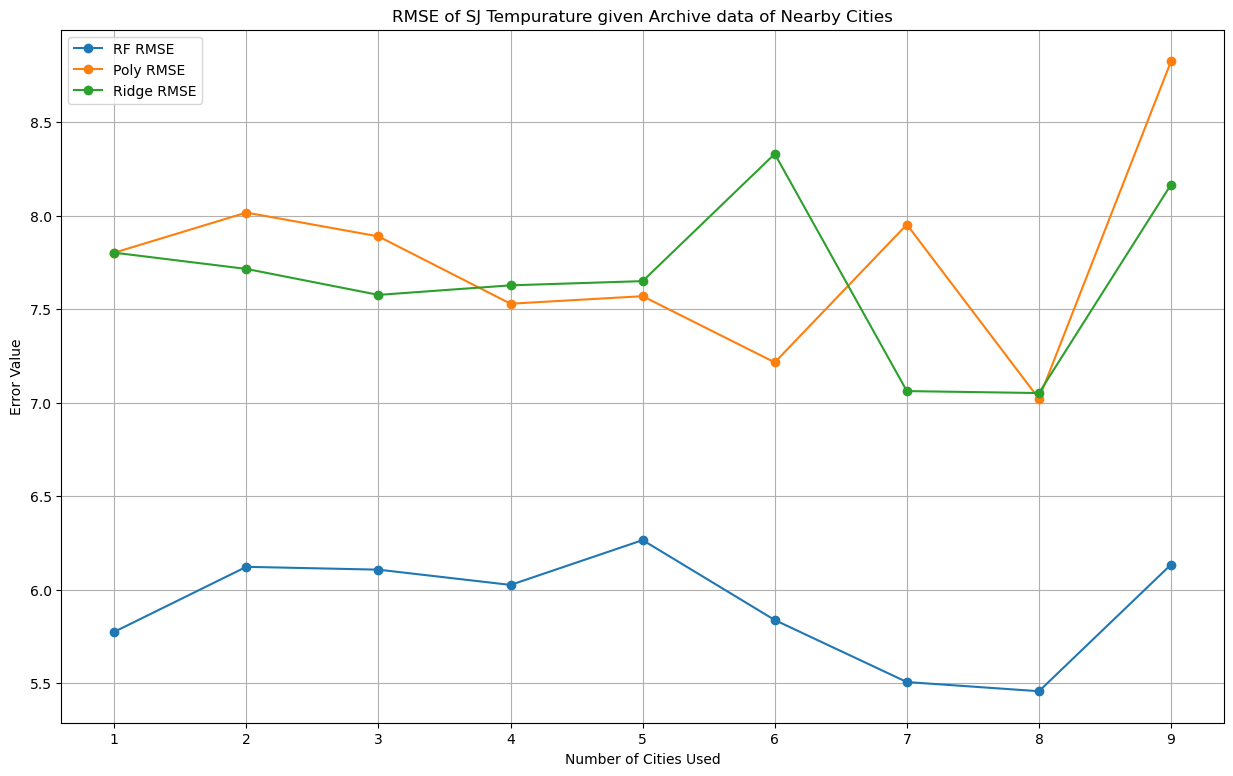

In [60]:
cityCount = [10 - i for i in range(9, 0, -1)]

plt.plot(cityCount, RFrmse, label="RF RMSE", marker="o")
plt.plot(cityCount, Polyrmse, label="Poly RMSE", marker="o")
plt.plot(cityCount, Ridgermse, label="Ridge RMSE", marker="o")
#plt.plot(cityCount, XGBrmse, label="XGB RMSE", marker="o")

plt.xlabel("Number of Cities Used")
plt.ylabel("Error Value")
plt.title("RMSE of SJ Tempurature given Archive data of Nearby Cities")

plt.legend()
plt.grid(True)
plt.savefig("Images/Predict_SJ_Temps_From_Archive_Regression.png")
plt.show()

# Attempting DNN approach for prediction

However, good results are unlikely due to these being tabular data on a series.

In [61]:
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        y = y.view(-1, 1)  # Reshape the target tensor to match the output tensor shape
        return torch.sqrt(self.mse(yhat, y))

In [62]:
# Universal Approximation Theorem
# We Tested Multiple Acitvation Functions and Found SiLU provided the best generalization by far

class DeepWeatherPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DeepWeatherPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.silu1 = nn.SiLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.silu2 = nn.SiLU()
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size * 4)
        self.silu3 = nn.SiLU()
        self.fc4 = nn.Linear(hidden_size * 4, hidden_size*2)
        self.silu4 = nn.SiLU()
        self.fc5 = nn.Linear(hidden_size * 2, hidden_size)
        self.silu5 = nn.SiLU()
        self.fc6 = nn.Linear(hidden_size, output)

    def forward(self, x):
        x = self.silu1(self.fc1(x))
        x = self.silu2(self.fc2(x))
        x = self.silu3(self.fc3(x))
        x = self.silu4(self.fc4(x))
        x = self.silu5(self.fc5(x))
        x = self.fc6(x)
        return x

In [63]:
def pData(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    X1 = scaler.transform(X_train)
    X2 = scaler.transform(X_test)
    return X1, X2

In [64]:
DFX_train, DFX_test, DFy_train, DFy_test = splitDF(processedForecast, "temperature_2m (°F)", .3)
DArchX_train, DArchX_test, DArchy_train, DArchy_test = splitDF(processedArchive, "temperature_2m (°F)", .3)

In [65]:
DFX_train, DFX_test = pData(DFX_train, DFX_test)
DArchX_train, DArchX_test = pData(DArchX_train, DArchX_test)

In [66]:
FDataTrain = WeatherDataset(DFX_train.astype(np.float64), DFy_train.values.astype(np.float64))
FDataTest = WeatherDataset(DFX_test.astype(np.float64), DFy_test.values.astype(np.float64))

Ftrainer = DataLoader(FDataTrain, batch_size=128, shuffle=True)
Ftester = DataLoader(FDataTest, batch_size=128, shuffle=False)

In [67]:
ArchDataTrain = WeatherDataset(DArchX_train.astype(np.float64), DArchy_train.values.astype(np.float64))
ArchDataTest = WeatherDataset(DArchX_test.astype(np.float64), DArchy_test.values.astype(np.float64))

# Training Model for DNN Approach

In [68]:
def trainModel(model, optimizer, criterion, trainer, tester, epochs, device):
    rmse_history = []
    for epoch in range(epochs):
        model.train()
        for idx, (data, target) in enumerate(trainer):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            target = target[:output.shape[0]]
            output = output.view(-1, 1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        model.eval()
        testLoss = 0
        
        with torch.no_grad():
            for data, target in tester:
                data, target = data.to(device), target.to(device)
                output = model(data)
                output = output.view(-1, 1)
                loss = criterion(output, target)
                testLoss += loss.item()
                
        testLoss /= len(tester)
        rmse_history.append(testLoss)
        print(f"Epoch: {epoch+1} | RMSE Test Loss: {testLoss:.4f}")
    return rmse_history, model

After some initial testing I found these parameters to be ideal to balance complexity and speed, while still maintaining
lowest RMSE and convergence. Originally RMSE was approximately 350, but ultimately reduced to the RMSE below

In [69]:
hidden = 128
output = 1

In [70]:
Fmodel = DeepWeatherPredictor(input_size=DFX_train.shape[1], hidden_size=hidden, output_size=output)
Fcriterion = RMSELoss()
Foptimizer = optim.Adam(Fmodel.parameters(), lr=0.0001)

In [71]:
epochs = 15 # We converge Rapidly on Forecast Data (Small Training Size)
FDNNRMSE, Forecast_DNN_Model = trainModel(Fmodel, Foptimizer, Fcriterion, Ftrainer, Ftester, epochs, device)
torch.save(Forecast_DNN_Model.state_dict(), 'Models/Forecast_DNN_Model.pt')

Epoch: 1 | RMSE Test Loss: 57.2826
Epoch: 2 | RMSE Test Loss: 57.0110
Epoch: 3 | RMSE Test Loss: 55.7030
Epoch: 4 | RMSE Test Loss: 50.3379
Epoch: 5 | RMSE Test Loss: 33.6781
Epoch: 6 | RMSE Test Loss: 11.9250
Epoch: 7 | RMSE Test Loss: 7.5685
Epoch: 8 | RMSE Test Loss: 5.9620
Epoch: 9 | RMSE Test Loss: 5.2657
Epoch: 10 | RMSE Test Loss: 4.7344
Epoch: 11 | RMSE Test Loss: 4.3199
Epoch: 12 | RMSE Test Loss: 4.0295
Epoch: 13 | RMSE Test Loss: 3.8486
Epoch: 14 | RMSE Test Loss: 3.6013
Epoch: 15 | RMSE Test Loss: 3.4700


In [72]:
Archmodel = DeepWeatherPredictor(input_size=DArchX_train.shape[1], hidden_size=hidden, output_size=output)
Acriterion = RMSELoss()
Aoptimizer = optim.Adam(Archmodel.parameters(), lr=0.0001)

In [73]:
# Archive Data takes significant time to converge, thus training time has been reduced through randomsplitting so
# the new reduced dataset is 5% of the original dataframe size. Given historical data is so large this should not 
# significantly effect prediction results.

num1 = int(0.05 * len(ArchDataTrain))
num2 = int(0.05 * len(ArchDataTest))
newNum1 = len(ArchDataTrain) - num1
newNum2 = len(ArchDataTest) - num2

reducedArchDataTrain, _ = random_split(ArchDataTrain, [num1, newNum1])
reducedArchDataTest, _ = random_split(ArchDataTest, [num2, newNum2])

Archtrainer = DataLoader(reducedArchDataTrain, batch_size=2048, shuffle=True)
Archtester = DataLoader(reducedArchDataTest, batch_size=2048, shuffle=False)

In [74]:
epochs = 15
ADNNRMSE, Archive_DNN_Model = trainModel(Archmodel, Aoptimizer, Acriterion, Archtrainer, Archtester, epochs, device)
torch.save(Archive_DNN_Model.state_dict(), 'Models/Archive_DNN_Model.pt')

Epoch: 1 | RMSE Test Loss: 59.5771
Epoch: 2 | RMSE Test Loss: 59.5213
Epoch: 3 | RMSE Test Loss: 59.4087
Epoch: 4 | RMSE Test Loss: 59.1533
Epoch: 5 | RMSE Test Loss: 58.5717
Epoch: 6 | RMSE Test Loss: 57.3160
Epoch: 7 | RMSE Test Loss: 54.7787
Epoch: 8 | RMSE Test Loss: 49.9560
Epoch: 9 | RMSE Test Loss: 41.6621
Epoch: 10 | RMSE Test Loss: 29.5379
Epoch: 11 | RMSE Test Loss: 18.9589
Epoch: 12 | RMSE Test Loss: 14.4654
Epoch: 13 | RMSE Test Loss: 11.4847
Epoch: 14 | RMSE Test Loss: 9.9993
Epoch: 15 | RMSE Test Loss: 9.2163


In [76]:
# Fine tune Archive Model to predict forecast data
epochs = 15
AonFDNNRMSE, Forecast_From_Archive_DNN_Model = trainModel(Archmodel, Aoptimizer, Acriterion, Ftrainer, Ftester, epochs, device)
torch.save(Forecast_From_Archive_DNN_Model.state_dict(), 'Models/Forecast_From_Archive_DNN_Model.pt')

Epoch: 1 | RMSE Test Loss: 5.5087
Epoch: 2 | RMSE Test Loss: 4.9494
Epoch: 3 | RMSE Test Loss: 4.5694
Epoch: 4 | RMSE Test Loss: 4.2637
Epoch: 5 | RMSE Test Loss: 4.0251
Epoch: 6 | RMSE Test Loss: 3.8235
Epoch: 7 | RMSE Test Loss: 3.6710
Epoch: 8 | RMSE Test Loss: 3.5114
Epoch: 9 | RMSE Test Loss: 3.4055
Epoch: 10 | RMSE Test Loss: 3.2944
Epoch: 11 | RMSE Test Loss: 3.2158
Epoch: 12 | RMSE Test Loss: 3.1450
Epoch: 13 | RMSE Test Loss: 3.0931
Epoch: 14 | RMSE Test Loss: 3.0398
Epoch: 15 | RMSE Test Loss: 2.9999


Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'RMSE')

Text(0.5, 1.0, 'RMSE of SJ Tempurature given Archive data of Nearby Cities')

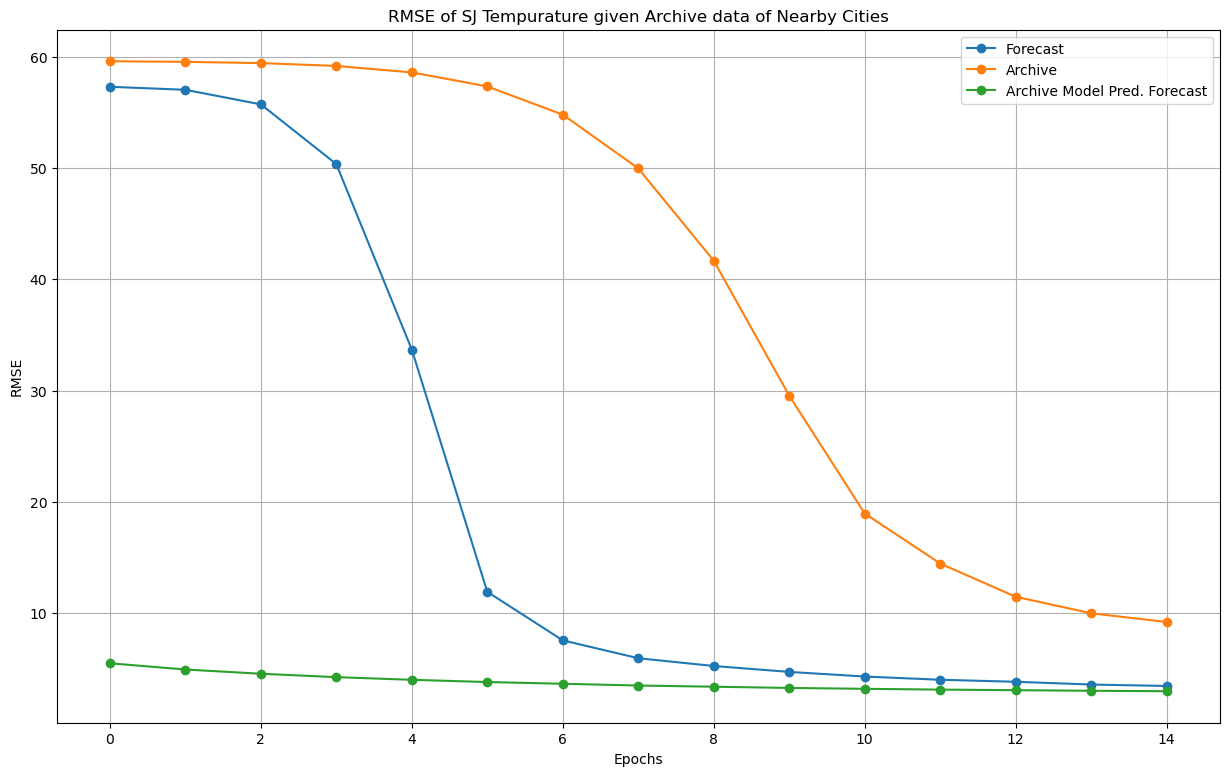

In [77]:
plt.plot(FDNNRMSE, label="Forecast", marker="o")
plt.plot(ADNNRMSE, label="Archive", marker="o")
plt.plot(AonFDNNRMSE, label="Archive Model Pred. Forecast", marker="o")

plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("RMSE of SJ Tempurature given Archive data of Nearby Cities")

plt.legend()
plt.grid(True)
plt.savefig("Images/Predict_SJ_Temps_From_Archive_DNN.png")
plt.show()

In [78]:
end_time = time.time()
total_time = end_time - start_time
total_time = total_time / 60
print(f"Elapsed Notebook Time: {total_time:.4f} Minutes")

Elapsed Notebook Time: 18.2831 Minutes


# Results

Overall, random forrest regression proved to be the best model for predicting weather tempuratures with DNNs falling 
closely behind. This approach demonstrates the feasibility of using local weather forecasting to predict the weather tempuratures of nearby cities. Utilizing these local models will certainly help researchers and others to predict the forecast accurately when used in tandem with other larger weather forecasting models. However, as a standalone model, these models are very good already. We may consider this as a form of fine tuning our predictions.

One important difference from my approach and the approach presented in https://arxiv.org/pdf/2008.10789.pdf is that I do not predict next day weather tempuratures using the current days data. The other is that the data presented in the paper was collected by the researchers own device and, more importantly, likely presented better results due to the physical location of the cities they used. In essence, they collected cities in a star formation around the city they desired to predict which likely gave significantly better results than my data. In my case the data collected has cities in the form of a horizontally stretch oval spanning the length of California's bay area from San Francicso to San Jose. Since I am predicting San Jose's weather the RMSE is likely significantly higher since it is on the edge of the physical data locations. Despite this, others can change the number on line 34 to the desired index of the city ID they want to predict from the list of cities on line 7.